In [2]:
# to_categorical is used to convert the Y to one-hot encoding
from tensorflow.keras.utils import to_categorical

# these libraries are used to create the model
from tensorflow.keras import models, layers, Input, regularizers, optimizers, callbacks

# train_test_split is used to split the training data into training and validation sets
from sklearn.model_selection import train_test_split

# matplotlib is used to create the plots
import seaborn as sns
import matplotlib.pyplot as plt

# numpy is used for array operations
import numpy as np

import pandas as pd


from tqdm import tqdm

In [3]:
RunsPerHyperparameterSet = 5
StepsPerHpRange = 5
Hyperparameters = {
	'learning_rate': (0.0001, 0.1),
	'batch_size': [256, 512, 1024],
	'epochs': [20],
	'layer_1': [16],
	'layer_2': [16],
	'layer_3': [0],
	'activation': ['relu'],
}


In [4]:
def PreprocessData(images_raw, labels_raw, numClasses):
	# reshape the data
	images = images_raw.reshape(images_raw.shape[0], images_raw.shape[1] * images_raw.shape[2])
	
	# normalize the data
	images = images.astype('float32') / 255

	# shuffle the data
	indices = np.arange(images.shape[0])
	np.random.shuffle(indices)
	images = images[indices]
	labels_raw = labels_raw[indices]

	# one-hot encode the labels
	testLabels_OneHot = to_categorical(labels_raw, num_classes=numClasses)

	return images, testLabels_OneHot

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100

Datasets = []

trainData, testData = mnist.load_data(path="mnist.npz")

trainData = PreprocessData(trainData[0], trainData[1], 10)
testData = PreprocessData(testData[0], testData[1], 10)
Datasets.append({
	'name': 'mnist',
	'trainData': trainData,
	'testData': testData
})

trainData, testData = fashion_mnist.load_data()
trainData = PreprocessData(trainData[0], trainData[1], 10)
testData = PreprocessData(testData[0], testData[1], 10)
Datasets.append({
	'name': 'fashion_mnist',
	'trainData': trainData,
	'testData': testData
})


In [6]:
# convert hyperparameters to a list of dictionaries
def hyperparameters_to_list(hyperparameters):
	for key, value in hyperparameters.items():
		if type(value) is tuple:
			hyperparameters[key] = np.linspace(value[0], value[1], StepsPerHpRange).tolist()

		elif type(value) is list:
			# make sure the list is long enough
			if len(value) < StepsPerHpRange:
				hyperparameters[key] = value * StepsPerHpRange
		
	hyperparameters_list = []
	for i in range(StepsPerHpRange):
		hyperparameters_list.append({})
		for key, value in hyperparameters.items():
			hyperparameters_list[i][key] = value[i]

	return hyperparameters_list

def CreateHpDataset():
	
	hpKeys = list(Hyperparameters.keys())
	# remove the epochs key
	hpKeys.remove('epochs')


	# define a dataframe to store the results
	hpDataset = pd.DataFrame(columns=hpKeys + ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'Dataset', 'Run', 'epoch'])
	return hpDataset

HyperParameterDataset = CreateHpDataset()

HyperparametersList = hyperparameters_to_list(Hyperparameters)
print(HyperparametersList[0])
print(HyperparametersList[1])
print(HyperparametersList[-1])

{'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}
{'learning_rate': 0.025075, 'batch_size': 512, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}
{'learning_rate': 0.1, 'batch_size': 512, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


In [7]:
def BuildModel(inputShape, outputNumber,
				layer1Neurons=-1,
				layer2Neurons=-1,
				layer3Neurons=-1,
				dropout=-1, l1=-1, l2=-1,
				optimizer="rmsprop",
				lr=0.001):


	def TryAddLayer(network, layerNeurons, dropout, l1, l2):
		if layerNeurons > 1:
			
			# check if we need to add a L1 or L2 
			if l1 > 0 or l2 > 0:
				network.add(layers.Dense(layerNeurons, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
			else:
				network.add(layers.Dense(layerNeurons, activation='relu'))


			# check if we need to add a drop out layer 
			if dropout > 0:
				network.add(layers.Dropout(dropout))


		return layerNeurons > 1

	network = models.Sequential()
	# input layer
	network.add(layers.Input(shape=(inputShape[1],)))

	if TryAddLayer(network, layer1Neurons, dropout, l1, l2):
		
		# only add the second hidden layer if the first one was added
		if TryAddLayer(network, layer2Neurons, dropout, l1, l2):

			# only add the third hidden layer if the second one was added
			TryAddLayer(network, layer3Neurons, dropout, l1, l2)

	# output layer
	network.add(layers.Dense(outputNumber, activation='softmax'))

	# define the optimizer
	if optimizer == "rmsprop":
		optimizer = optimizers.RMSprop(learning_rate=lr)
	elif optimizer == "adam":
		optimizer = optimizers.Adam(learning_rate=lr)
	elif optimizer == "adadelta":
		optimizer = optimizers.Adadelta(learning_rate=lr)
	elif optimizer == "adamax":
		optimizer = optimizers.Adamax(learning_rate=lr)
	elif optimizer == "nadam":
		optimizer = optimizers.Nadam(learning_rate=lr)
	elif optimizer == "sgd":
		optimizer = optimizers.SGD(learning_rate=lr)
	else:
		raise Exception("Unknown optimizer: " + optimizer)
	
	# compile the network
	network.compile(
		optimizer=optimizer,
		loss='categorical_crossentropy',
		metrics=['accuracy'])
	
	return network

def Train(network, trainInputs, trainTargets,
			epochs, batchSize,
			validationData=None,
			callbackList=[], verbose=1):

	# train the network
	history = network.fit(
		trainInputs, trainTargets,
		shuffle=True,
		epochs=epochs, batch_size=batchSize,
		validation_data=validationData,
		callbacks=callbackList, 
		verbose=verbose)
	return history

In [8]:
def TestHyperparameters(datasetName, trainData, testData, hp, i):
	# create the model
	model = BuildModel(
		inputShape=trainData[0].shape,
		outputNumber=10,
		layer1Neurons=hp['layer_1'],
		layer2Neurons=hp['layer_2'],
		layer3Neurons=hp['layer_3'],
		lr=hp['learning_rate'])

	# train the model
	history = Train(
		model,
		trainData[0], trainData[1],
		epochs=hp['epochs'],
		batchSize=hp['batch_size'],
		validationData=testData,
		callbackList=[],
		verbose=0)
	
	# add the results to the dataframe
	# append to the end of the dataframe

	for epoch in range(hp['epochs']):
		# get the results for this epoch
		epochResults = {
			'accuracy': history.history['accuracy'][epoch],
			'loss': history.history['loss'][epoch],
			'val_accuracy': history.history['val_accuracy'][epoch],
			'val_loss': history.history['val_loss'][epoch],
			'Dataset': datasetName,
			'Run': i,
			'epoch': epoch+1
		}

		# add the hyperparameters to the results
		for key, value in hp.items():
			if key == "epochs":
				continue

			epochResults[key] = value

		# add the results to the dataframe
		HyperParameterDataset.loc[len(HyperParameterDataset)] = epochResults

	return

def GridSearch(datasetName, trainData, testData, hpList):
	print(f"Grid Search for {datasetName}")
	
	for hp in hpList:
		print("Testing hyperparameters: ", hp)
		
		# for i in range(RunsPerHyperparameterSet):
		# add a loading bar
		for i in tqdm(range(RunsPerHyperparameterSet)):
			TestHyperparameters(datasetName, trainData, testData, hp, i)
	return

In [9]:
HyperParameterDataset = CreateHpDataset()

for dataset in Datasets:
	name = dataset['name']
	trainData = dataset['trainData']
	testData = dataset['testData']
	GridSearch(name, trainData, testData, HyperparametersList)

Grid Search for mnist
Testing hyperparameters:  {'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:48<00:00, 21.79s/it]


Testing hyperparameters:  {'learning_rate': 0.025075, 'batch_size': 512, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


Testing hyperparameters:  {'learning_rate': 0.050050000000000004, 'batch_size': 1024, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:10<00:00, 14.06s/it]


Testing hyperparameters:  {'learning_rate': 0.07502500000000001, 'batch_size': 256, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:47<00:00, 21.53s/it]


Testing hyperparameters:  {'learning_rate': 0.1, 'batch_size': 512, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


Grid Search for fashion_mnist
Testing hyperparameters:  {'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:59<00:00, 23.88s/it]


Testing hyperparameters:  {'learning_rate': 0.025075, 'batch_size': 512, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:32<00:00, 18.44s/it]


Testing hyperparameters:  {'learning_rate': 0.050050000000000004, 'batch_size': 1024, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:14<00:00, 14.97s/it]


Testing hyperparameters:  {'learning_rate': 0.07502500000000001, 'batch_size': 256, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:56<00:00, 23.22s/it]


Testing hyperparameters:  {'learning_rate': 0.1, 'batch_size': 512, 'epochs': 20, 'layer_1': 16, 'layer_2': 16, 'layer_3': 0, 'activation': 'relu'}


100%|██████████| 5/5 [01:32<00:00, 18.56s/it]


In [14]:
print(f"Length of the dataset: {len(HyperParameterDataset)}")
HyperParameterDataset.head()

Length of the dataset: 1000


,learning_rate,batch_size,layer_1,layer_2,layer_3,activation,accuracy,loss,val_accuracy,val_loss,Dataset,Run,epoch
0,0.0001,256,16,16,0,relu,0.359383,2.019515,0.5424,1.716815,mnist,0,1
1,0.0001,256,16,16,0,relu,0.645650,1.473297,0.7232,1.227311,mnist,0,2
2,0.0001,256,16,16,0,relu,0.737217,1.072109,0.7768,0.894209,mnist,0,3
3,0.0001,256,16,16,0,relu,0.797967,0.806190,0.8338,0.690242,mnist,0,4
4,0.0001,256,16,16,0,relu,0.838333,0.648350,0.8555,0.573802,mnist,0,5


In [15]:
# save the results to a csv file
HyperParameterDataset.to_csv("HyperParameterDataset.csv", index=False)

In [23]:
cmap = plt.get_cmap('tab10')

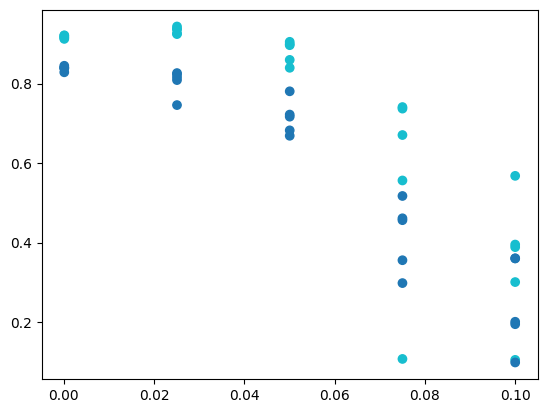

In [24]:
# plot the results, want to see how the accuracy changes over the learning rate 

# select the last epoch for each run
hpData = HyperParameterDataset[HyperParameterDataset['epoch'] == HyperParameterDataset['epoch'].max()]
datasetLabelsInts = hpData['Dataset'].astype('category').cat.codes

plt.scatter(hpData['learning_rate'], hpData['accuracy'], label='accuracy', c=datasetLabelsInts, cmap=cmap)
plt.show()

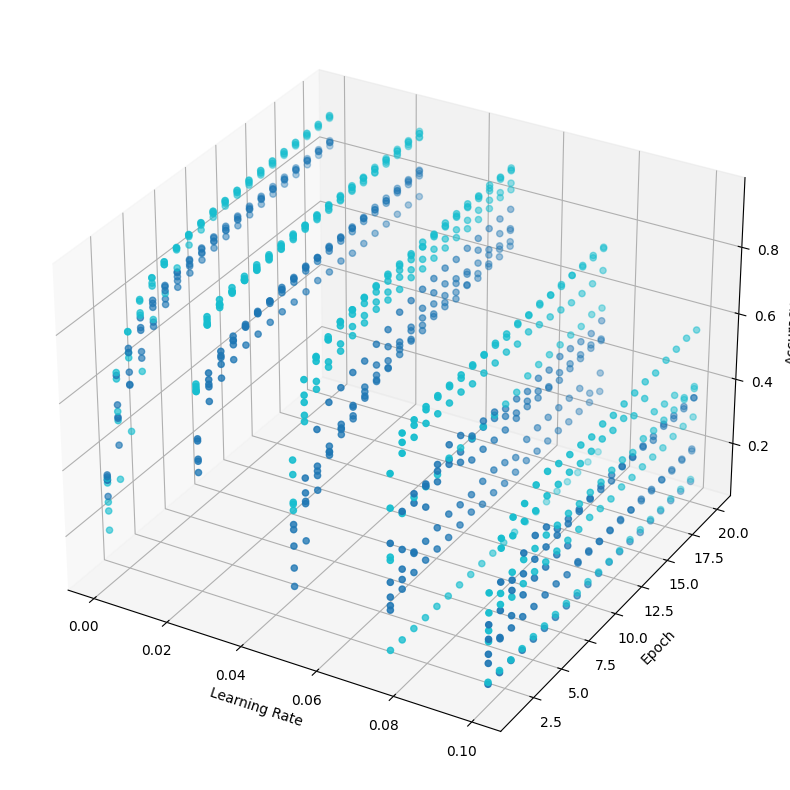

In [26]:
hpData = HyperParameterDataset
datasetLabelsInts = hpData['Dataset'].astype('category').cat.codes

cmap = plt.get_cmap('tab10')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(hpData['learning_rate'], hpData['epoch'], hpData['accuracy'], c=datasetLabelsInts, cmap=cmap)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Epoch')
ax.set_zlabel('Accuracy')

plt.show()